## Model evaluation

* [Task description](#Task-description)
* [Research configuration](#Research-configuration)
* [Results](#Results)


## Task description

For model performance assessment we want to obtain the distribution of the model accuracy over N independent runs of the training procedure.

In [1]:
import os
import sys
import glob
import dill
import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(0, os.path.join("..", ".."))
from batchflow import B, V, C, Pipeline
from batchflow.opensets import MNIST
from batchflow.models.tf import TFModel
from batchflow.research import Research, Results

from src import show_histogram

## Research configuration

Dataset loading

In [2]:
dataset = MNIST(bar=True)

100%|██████████| 8/8 [00:20<00:00,  4.04s/it]


Define the model config:

In [3]:
NUM_CLASSES = 10

model_config = {
    'inputs/images/shape': B('image_shape'),
    'inputs/labels/classes': NUM_CLASSES,
    'initial_block/inputs': 'images',
    'body': dict(layout='cpna cpna cpna', filters=[64, 128, 256],
                 strides=2, pool_strides=1, kernel_size=3),
    'head': dict(layout='Pf', units=NUM_CLASSES),
    'loss': 'crossentropy',
    'optimizer': ('Momentum', {'use_nesterov': True, 'learning_rate': 0.01, 'momentum': 0.5}),
    'output': ['proba']}

Define training and test pipelines:

In [4]:
train_template = (Pipeline()
                  .init_variable('loss_history', init_on_each_run=list)
                  .init_model('dynamic', TFModel, 'mnist_model', config=model_config)
                  .to_array()
                  .train_model('mnist_model', fetches='loss', images=B('images'), labels=B('labels'), 
                               save_to=V('loss_history', mode='a'))
                  .run_later(64, shuffle=True, n_epochs=1, drop_last=True, bar=False))

In [5]:
test_template = (Pipeline()
                 .import_model('mnist_model', C('import_from'))
                 .init_variable('predictions', init_on_each_run=list)
                 .init_variable('metrics', init_on_each_run=None)
                 .to_array()
                 .predict_model('mnist_model', fetches='proba', images=B('images'),
                                save_to=V('predictions'))
                 .gather_metrics('class', targets=B('labels'), predictions=V('predictions'),
                                 fmt='proba', axis=-1, save_to=V('metrics', mode='u'))
                 .run_later(64, shuffle=False, n_epochs=1, drop_last=True, bar=False))

Create a research object and run 20 independent training and test procedures:

In [6]:
research = (Research()
            .add_pipeline(train_template, dataset=dataset.train, name='train', execute=-1, run=True)
            .add_pipeline(test_template, dataset=dataset.test, variables='metrics', name='test', import_from='train', execute=-1, run=True)
            .run(n_reps=20, n_iters=1, name='model_evaluation', bar=True))

Research model_evaluation is starting...


  0%|          | 0/20 [00:00<?, ?it/s]

Distributor has 20 jobs with 1 iterations. Totally: 20


 95%|█████████▌| 19/20 [30:35<01:36, 96.58s/it]


## Results

Save accuracy metric to an array

In [8]:
df = Results(path='model_evaluation').load()
values = df[df['name'] == 'test']['metrics'].apply(lambda x: x.evaluate('accuracy')).values

Accuracy histogram and the average value

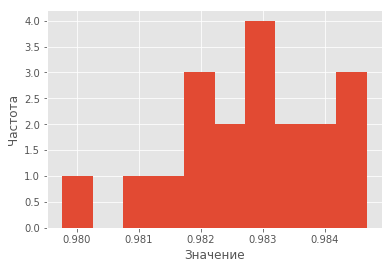

The average value (median) is 0.983


In [9]:
show_histogram(values)
print('The average value (median) is %.3f' % np.median(values))